In [2]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import seaborn as sns

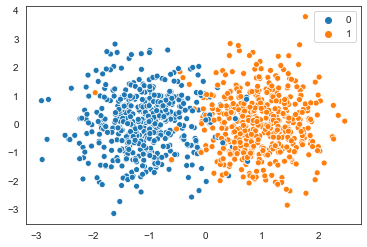

In [32]:
# creating data from inbuilt sklearn dataset
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, n_informative=1,
                             n_clusters_per_class=1, random_state=14)

m = len(y)
y = np.reshape(y,(m, 1))

# appending labels and feature columns
training_data = np.append(X, y, 1)

sns.set_style('white')
sns.scatterplot(X[:,0],X[:,1],hue=y.reshape(-1));

In [33]:
# Column labels.
# These are used only to print the tree.
header = ["feature1", "feature2", "label"]

In [34]:
# Find the unique values for a column in a dataset
def unique_vals(rows, col):
    return set([row[col] for row in rows])

In [35]:
unique_vals(training_data, 2)

{0.0, 1.0}

In [38]:
# Counts the number of each type of example in a dataset
def class_counts(rows):
    counts = {}  # a dictionary of label -> count.
    for row in rows:
        # in our dataset format, the label is always the last column
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [39]:
class_counts(training_data)

{0.0: 502, 1.0: 498}

In [40]:
# Test if a value is numeric
def is_numeric(value):
    return isinstance(value, int) or isinstance(value, float)

In [41]:
# A Question is used to partition a dataset
class Question:
   
    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        # Compare the feature value in an example to the
        # feature value in this question.
        val = example[self.column]
        if is_numeric(val):
            return val >= self.value
        else:
            return val == self.value

    def __repr__(self):
        # This is just a helper method to print
        # the question in a readable format.
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Is %s %s %s?" % (
            header[self.column], condition, str(self.value))

In [42]:
Question(1, 3)

Is feature2 >= 3?

In [45]:
# Partitions a dataset
def partition(rows, question):
# For each row in the dataset, check if it matches the question. If so, add it to 'true rows', otherwise, add it to 'false rows'
    true_rows, false_rows = [], []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
    return true_rows, false_rows

In [46]:
# Calculate the Gini Impurity for a list of rows
def gini(rows):

    counts = class_counts(rows)
    impurity = 1
    for lbl in counts:
        prob_of_lbl = counts[lbl] / float(len(rows))
        impurity -= prob_of_lbl**2
    return impurity

In [47]:
# he uncertainty of the starting node, minus the weighted impurity of two child nodes
def info_gain(left, right, current_uncertainty):

    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

In [48]:
# Find the best question to ask by iterating over every feature / value and calculating the information gain
def find_best_split(rows):
    best_gain = 0  # keep track of the best information gain
    best_question = None  # keep train of the feature / value that produced it
    current_uncertainty = gini(rows)
    n_features = len(rows[0]) - 1  # number of columns

    for col in range(n_features):  # for each feature

        values = set([row[col] for row in rows])  # unique values in the column

        for val in values:  # for each value

            question = Question(col, val)

            # try splitting the dataset
            true_rows, false_rows = partition(rows, question)

            # Skip this split if it doesn't divide the
            # dataset.
            if len(true_rows) == 0 or len(false_rows) == 0:
                continue

            # Calculate the information gain from this split
            gain = info_gain(true_rows, false_rows, current_uncertainty)

            # You actually can use '>' instead of '>=' here
            # but I wanted the tree to look a certain way for our
            # toy dataset.
            if gain >= best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

In [49]:
# A Leaf node classifies data

# his holds a dictionary of class (e.g., 0.0) -> number of times it appears in the rows from the training data that reach this leaf.
class Leaf:

    def __init__(self, rows):
        self.predictions = class_counts(rows)

In [50]:
# A Decision Node asks a question. This holds a reference to the question, and to the two child nodes
class Decision_Node:

    def __init__(self,
                 question,
                 true_branch,
                 false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [51]:
def build_tree(rows):

    # Try partitioing the dataset on each of the unique attribute,
    # calculate the information gain,
    # and return the question that produces the highest gain.
    gain, question = find_best_split(rows)

    # Base case: no further info gain
    # Since we can ask no further questions,
    # we'll return a leaf.
    if gain == 0:
        return Leaf(rows)

    # If we reach here, we have found a useful feature / value
    # to partition on.
    true_rows, false_rows = partition(rows, question)

    # Recursively build the true branch.
    true_branch = build_tree(true_rows)

    # Recursively build the false branch.
    false_branch = build_tree(false_rows)

    # Return a Question node.
    # This records the best feature / value to ask at this point,
    # as well as the branches to follow
    # dependingo on the answer.
    return Decision_Node(question, true_branch, false_branch)

In [52]:
def print_tree(node, spacing=""):

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    # Print the question at this node
    print (spacing + str(node.question))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    

In [53]:
my_tree = build_tree(training_data)

In [54]:
print_tree(my_tree)

Is feature1 >= -0.07071678678023519?
--> True:
  Is feature1 >= 0.09155131260192473?
  --> True:
    Is feature1 >= 0.30757613481101564?
    --> True:
      Is feature1 >= 0.7480600507814352?
      --> True:
        Is feature1 >= 1.0748793347740846?
        --> True:
          Predict {1.0: 221}
        --> False:
          Is feature1 >= 1.0746526132495713?
          --> True:
            Predict {0.0: 1}
          --> False:
            Predict {1.0: 109}
      --> False:
        Is feature1 >= 0.7459970164712222?
        --> True:
          Predict {0.0: 1}
        --> False:
          Is feature1 >= 0.7264260291284783?
          --> True:
            Is feature1 >= 0.7310222460318117?
            --> True:
              Predict {1.0: 5}
            --> False:
              Predict {0.0: 2}
          --> False:
            Is feature2 >= -1.7593229568509194?
            --> True:
              Is feature1 >= 0.5301592599451289?
              --> True:
                Predict {1.0: 

In [55]:
def classify(row, node):

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        return node.predictions

    # Decide whether to follow the true-branch or the false-branch.
    # Compare the feature / value stored in the node,
    # to the example we're considering.
    if node.question.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)

In [56]:
def print_leaf(counts):
    total = sum(counts.values()) * 1.0
    probs = {}
    for lbl in counts.keys():
        probs[lbl] = str(int(counts[lbl] / total * 100)) + "%"
    return probs

In [57]:
print_leaf(classify(training_data[0], my_tree))

{0.0: '100%'}

In [58]:
print_leaf(classify(training_data[1], my_tree))

{0.0: '100%'}

In [90]:
a = [] # for storing actual values
b = [] # for storing predicted values
for row in training_data:
    print ("Actual: %s. Predicted: %s" %
           (row[-1], print_leaf(classify(row, my_tree))))
    b.append(next(iter(classify(row, my_tree))))
    a.append(row[-1])

Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 0.0. Predicted: {0.0: '100%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 1.0. Predicted: {1.0: '100%'}
Actual: 1.0.

In [91]:
# finding accuracy of predictions by converting the lists to arrays
a = np.array(a)
b = np.array(b)
accuracy = float(sum(a == b))/ float(len(b))

print(accuracy)

0.946
